In [6]:
import os
#from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
import sys
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pickle as pkl
import time
import import_ipynb
from mymodelC import CFIN
from matplotlib import pyplot
from tensorflow.keras.utils import plot_model

#params: 240929
[1] train-result=0.8445, valid-result=0.8435, valid-f1=0.8987 [136.2 s]
[2] train-result=0.8460, valid-result=0.8447, valid-f1=0.9014 [128.2 s]
[3] train-result=0.8486, valid-result=0.8480, valid-f1=0.9015 [131.2 s]
[4] train-result=0.8495, valid-result=0.8490, valid-f1=0.9017 [129.4 s]
[5] train-result=0.8510, valid-result=0.8504, valid-f1=0.9019 [137.0 s]
[6] train-result=0.8512, valid-result=0.8503, valid-f1=0.9021 [134.1 s]
[7] train-result=0.8517, valid-result=0.8514, valid-f1=0.9018 [144.5 s]
[8] train-result=0.8530, valid-result=0.8524, valid-f1=0.9033 [136.3 s]
[9] train-result=0.8536, valid-result=0.8524, valid-f1=0.9031 [143.2 s]
[10] train-result=0.8536, valid-result=0.8528, valid-f1=0.9025 [141.0 s]
[11] train-result=0.8548, valid-result=0.8532, valid-f1=0.9043 [148.4 s]
[12] train-result=0.8552, valid-result=0.8539, valid-f1=0.9031 [144.2 s]
[13] train-result=0.8554, valid-result=0.8538, valid-f1=0.9035 [127.4 s]
[14] train-result=0.8560, valid-result=0.854

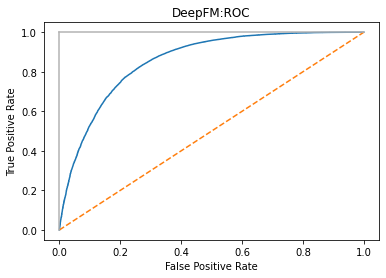

,all#count,session#count,seek_video#num,play_video#num,pause_video#num,stop_video#num,load_video#num,problem_get#num,problem_check#num,problem_save#num,...,create_thread#num#course#max,create_comment#num#course#max,delete_thread#num#course#max,delete_comment#num#course#max,click_info#num#course#max,click_courseware#num#course#max,click_about#num#course#max,click_forum#num#course#max,click_progress#num#course#max,close_courseware#num#course#max
enroll_id,,,,,,,,,,,,,,,,,,,,,
772,-0.228387,-0.228387,-0.243043,-0.296739,-0.333535,-0.059298,-0.480968,-0.042412,-0.305844,-0.202161,...,15.334961,10.209764,20.885492,-0.037288,5.024257,2.699534,4.791379,5.770228,4.713969,3.232602
773,-0.204883,-0.204883,-0.115253,-0.242027,-0.296012,-0.059298,-0.445267,-0.042412,-0.305844,-0.202161,...,15.334961,10.209764,20.885492,-0.037288,5.024257,2.699534,4.791379,5.770228,4.713969,3.232602
774,-0.139320,-0.139320,-0.051358,-0.105248,-0.208460,-0.057709,-0.195358,-0.042412,-0.305844,-0.202161,...,15.334961,10.209764,20.885492,-0.037288,5.024257,2.699534,4.791379,5.770228,4.713969,3.232602
776,-0.207357,-0.207357,-0.243043,-0.255705,-0.296012,-0.057709,-0.409566,-0.042412,-0.305844,-0.202161,...,15.334961,10.209764,20.885492,-0.037288,5.024257,2.699534,4.791379,5.770228,4.713969,3.232602
777,-0.225912,-0.225912,-0.243043,-0.296739,-0.333535,-0.059298,-0.480968,-0.042412,-0.305844,-0.202161,...,15.334961,10.209764,20.885492,-0.037288,5.024257,2.699534,4.791379,5.770228,4.713969,3.232602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466774,-0.178905,-0.178905,-0.243043,-0.296739,-0.308520,-0.059298,-0.409566,-0.024969,-0.079424,-0.202161,...,23.054902,9.740966,10.432693,6.551436,11.387396,3.821487,12.686626,8.297949,9.258301,3.776265
466776,-0.207357,-0.207357,-0.179148,-0.269383,-0.308520,-0.057709,-0.409566,-0.042412,-0.305844,-0.202161,...,23.054902,9.740966,10.432693,6.551436,11.387396,3.821487,12.686626,8.297949,9.258301,3.776265
466781,-0.194987,-0.194987,-0.243043,-0.296739,-0.333535,-0.059298,-0.480968,0.021545,-0.305844,-0.202161,...,23.054902,9.740966,10.432693,6.551436,11.387396,3.821487,12.686626,8.297949,9.258301,3.776265


In [14]:

os.environ['CUDA_VISIBLE_DEVICES'] = '2,4'
act_feat_basic = pkl.load(open('act_feats.pkl', 'rb'))

#user_cat_feat = ['gender', 'cluster_label']
user_cat_feat = ['gender','education', 'cluster_label']
user_num_feat = ['age', 'user_enroll_num']
course_cat_feat = ['course_category']
course_num_feat = ['course_enroll_num']


def feat_augment(train_feat, test_feat):
    act_feats = pkl.load(open('act_feats.pkl', 'rb'))
    all_feat = pd.concat([train_feat, test_feat])
    all_feat_u_mean = all_feat.groupby('username').mean()[act_feats]
    all_feat_u_mean.columns = [x + '#user#mean' for x in all_feat_u_mean.columns]
    all_feat_u_max = all_feat.groupby('username').max()[act_feats]
    all_feat_u_max.columns = [x + '#user#max' for x in all_feat_u_max.columns]

    all_feat = pd.merge(all_feat, all_feat_u_mean, right_index=True, left_on='username')
    all_feat = pd.merge(all_feat, all_feat_u_max, right_index=True, left_on='username')

    all_feat_c_mean = all_feat.groupby('course_id').mean()[act_feats]
    all_feat_c_mean.columns = [x + '#course#mean' for x in all_feat_c_mean.columns]

    all_feat_c_max = all_feat.groupby('course_id').max()[act_feats]
    all_feat_c_max.columns = [x + '#course#max' for x in all_feat_c_max.columns]

    all_feat = pd.merge(all_feat, all_feat_c_mean, right_index=True, left_on='course_id')
    all_feat = pd.merge(all_feat, all_feat_c_max, right_index=True, left_on='course_id')

    act_feat = []
    for f in act_feat_basic:
        act_feat.append(f)
        act_feat.append(f + '#user#mean')
        act_feat.append(f + '#user#max')
        act_feat.append(f + '#course#mean')
        act_feat.append(f + '#course#max')

    return all_feat.loc[train_feat.index], all_feat.loc[test_feat.index], act_feat


def dataparse(train, test, num_feat, cat_feat):
    all_data = pd.concat([train, test])
    feat_dim = 0
    feat_dict = dict()
    for f in cat_feat:
        cat_val = all_data[f].unique()
        feat_dict[f] = dict(zip(cat_val, range(feat_dim, len(cat_val) + feat_dim)))
        feat_dim += len(cat_val)
    for f in num_feat:
        feat_dict[f] = feat_dim
        feat_dim += 1
    data_indice = all_data.copy()
    data_value = all_data.copy()
    for f in all_data.columns:
        if f in num_feat:
            data_indice[f] = feat_dict[f]
        elif f in cat_feat:
            data_indice[f] = data_indice[f].map(feat_dict[f])
            data_value[f] = 1.
        else:
            data_indice.drop(f, axis=1, inplace=True)
            data_value.drop(f, axis=1, inplace=True)
    return feat_dim, data_indice, data_value


def load_data():
    dfTrain = pd.read_csv('SVMData/train_feat.csv', index_col=0)
    dfTest = pd.read_csv('SVMData/test_feat.csv', index_col=0)
    dfTrain_u = dfTrain[user_num_feat + user_cat_feat + ['truth']]
    dfTest_u = dfTest[user_num_feat + user_cat_feat + ['truth']]

    dfTrain_c = dfTrain[course_num_feat + course_cat_feat + ['truth']]
    dfTest_c = dfTest[course_num_feat + course_cat_feat + ['truth']]
    dfTrain_a = dfTrain[act_feat_basic + course_cat_feat + ['truth', 'username', 'course_id']]
    dfTest_a = dfTest[act_feat_basic + course_cat_feat + ['truth', 'username', 'course_id']]

    return dfTrain_u, dfTest_u, dfTrain_c, dfTest_c, dfTrain_a, dfTest_a


def model_run(dfTrain_u, dfTest_u, dfTrain_c, dfTest_c, dfTrain_a, dfTest_a, params, act_feat):
    u_feat_dim, u_data_indice, u_data_value = dataparse(dfTrain_u, dfTest_u, user_num_feat, user_cat_feat)
    ui_train, uv_train = np.asarray(u_data_indice.loc[dfTrain_u.index], dtype=int), np.asarray(
        u_data_value.loc[dfTrain_u.index], dtype=float)
    ui_test, uv_test = np.asarray(u_data_indice.loc[dfTest_u.index], dtype=int), np.asarray(
        u_data_value.loc[dfTest_u.index], dtype=float)

    params["u_feat_size"] = u_feat_dim
    params["u_field_size"] = len(ui_train[0])

    c_feat_dim, c_data_indice, c_data_value = dataparse(dfTrain_c, dfTest_c, course_num_feat, course_cat_feat)
    ci_train, cv_train = np.asarray(c_data_indice.loc[dfTrain_c.index], dtype=int), np.asarray(
        c_data_value.loc[dfTrain_c.index], dtype=float)
    ci_test, cv_test = np.asarray(c_data_indice.loc[dfTest_c.index], dtype=int), np.asarray(
        c_data_value.loc[dfTest_c.index], dtype=float)

    params["c_feat_size"] = c_feat_dim
    params["c_field_size"] = len(ci_train[0])

    av_train = np.asarray(dfTrain_a[act_feat], dtype=float)

    ai_train = np.asarray([range(len(act_feat)) for x in range(len(dfTrain_a))], dtype=int)
    av_test = np.asarray(dfTest_a[act_feat], dtype=float)
    ai_test = np.asarray([range(len(act_feat)) for x in range(len(dfTest_a))], dtype=int)

    params["a_feat_size"] = len(ai_train[0])
    params["a_field_size"] = len(ai_train[0])

    y_train = np.asarray(dfTrain_a['truth'], dtype=int)
    y_test = np.asarray(dfTest_a['truth'], dtype=int)
    model = CFIN(**params)

    # generate valid set
    train_num = len(y_train)
    indices = np.arange(train_num)
    np.random.shuffle(indices)
    split_ = int(0.8 * train_num)
    ui_train_, ui_valid = ui_train[indices][:split_], ui_train[indices[split_:]]
    uv_train_, uv_valid = uv_train[indices][:split_], uv_train[indices[split_:]]
    ci_train_, ci_valid = ci_train[indices][:split_], ci_train[indices[split_:]]
    cv_train_, cv_valid = cv_train[indices][:split_], cv_train[indices[split_:]]
    ai_train_, ai_valid = ai_train[indices][:split_], ai_train[indices[split_:]]
    av_train_, av_valid = av_train[indices[:split_]], av_train[indices[split_:]]
    y_train_, y_valid = y_train[indices[:split_]], y_train[indices[split_:]]

    # model selection
    """
    best_epoch = model.fit(ui_train_, uv_train_, ci_train_, cv_train_, ai_train_, av_train_, y_train_, ui_valid, uv_valid, ci_valid, cv_valid, ai_valid, av_valid, y_valid)
    params['epoch'] = best_epoch
    model = CFIN(**params)
    """
    start_time = time.time()
    # train
    history = model.fit(ui_train, uv_train, ci_train, cv_train, ai_train, av_train, y_train, ui_test, uv_test, ci_test, cv_test,
              ai_test, av_test, y_test, early_stopping=False)
    print("Time elapsed {} seconds".format(time.time() - start_time))

    # prediction results on test set
    model.evaluate(ui_test, uv_test, ci_test, cv_test, ai_test, av_test, y_test)
    print(model.evaluate(ui_test, uv_test, ci_test, cv_test, ai_test, av_test, y_test))
    yy, pred_ans = model.predict(ui_test, uv_test, ci_test, cv_test, ai_test, av_test)
    print(model.predict(ui_test, uv_test, ci_test, cv_test, ai_test, av_test))
    score1 = pred_ans
    f, t , threshold = roc_curve(y_test, score1)
    pyplot.title('DeepFM:ROC')
    pyplot.plot(f, t)
    pyplot.plot([0, 1], ls="--")
    pyplot.plot([0, 0], [1, 0] , c=".7"), pyplot.plot([1, 1] , c=".7")
    pyplot.ylabel('True Positive Rate')
    pyplot.xlabel('False Positive Rate')
    pyplot.show()
    
    ##ExtraCode

    

# load data
dfTrain_u, dfTest_u, dfTrain_c, dfTest_c, dfTrain_a, dfTest_a = load_data()
dfTrain_a, dfTest_a, act_feat = feat_augment(dfTrain_a, dfTest_a)

params = {
    "embedding_size": 32,
    "attn_size": 16,
    "conv_size": 512,
    "context_size": 32,
    "deep_layers": [256],
    "dropout_deep": [0.9, 0.9],
    "dropout_attn": [1.],
    "activation": tf.nn.relu,
    "epoch": 32,
    "batch_size": 32,
    "learning_rate": 0.0001,
    "optimizer_type": "adam",
    "batch_norm": 1,
    "batch_norm_decay": 0.995,
    "l2_reg": 0.00001,
    "verbose": True,
    "attn": True,
    "eval_metric": roc_auc_score,
    "random_seed": 12345
}

# y_train_dfm, y_test_dfm = model_run(dfTrain_u, dfTest_u, dfTrain_c, dfTest_c, dfTrain_a, dfTest_a,params, act_feat)
model_run(dfTrain_u, dfTest_u, dfTrain_c, dfTest_c, dfTrain_a, dfTest_a, params, act_feat)
dfTrain_a

In [8]:
model.summary()


NameError: name 'model' is not defined

In [9]:
score1 = pred_ans
f, t , threshold = roc_curve(y_test, score1)
pyplot.title('DeepFM:ROC')
pyplot.plot(f, t)
pyplot.plot([0, 1], ls="--")
pyplot.plot([0, 0], [1, 0] , c=".7"), pyplot.plot([1, 1] , c=".7")
pyplot.ylabel('True Positive Rate')
pyplot.xlabel('False Positive Rate')
pyplot.show()


NameError: name 'pred_ans' is not defined

In [ ]:
dfTrain_c['course_category'].unique()

In [12]:
act_feat_basic

['all#count',
 'session#count',
 'seek_video#num',
 'play_video#num',
 'pause_video#num',
 'stop_video#num',
 'load_video#num',
 'problem_get#num',
 'problem_check#num',
 'problem_save#num',
 'reset_problem#num',
 'problem_check_correct#num',
 'problem_check_incorrect#num',
 'create_thread#num',
 'create_comment#num',
 'delete_thread#num',
 'delete_comment#num',
 'click_info#num',
 'click_courseware#num',
 'click_about#num',
 'click_forum#num',
 'click_progress#num',
 'close_courseware#num']